### Edge based encoding

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from frites.plot import plot_conn_circle, plot_conn_heatmap
from frites.stats import confidence_interval
from frites.utils import parallel_func
from scipy.signal import fftconvolve
from tqdm import tqdm
from utils import *

from config import get_dates, return_delay_split
from GDa.flatmap.flatmap import flatmap
from GDa.graphics import plot
from GDa.loader import loader
from GDa.temporal_network import temporal_network
from GDa.util import _extract_roi, shuffle_along_axis

##### Setting configurations

In [3]:
_ROOT = os.path.expanduser("~/funcog/gda/")

In [4]:
metric = "coh"
monkey = "ethyl"
ds = 1

In [5]:
early_cue, early_delay = return_delay_split(monkey, delay_type=ds)

In [6]:
sessions = get_dates(monkey)

In [7]:
reg_colors = dict(
    zip(
        [
            "motor",
            "parietal",
            "prefrontal",
            "somatosensory",
            "temporal",
            "visual",
            "auditory",
        ],
        ["r", "aqua", "b", "m", "goldenrod", "green", "brown"],
    )
)

In [8]:
stages = [[-0.4, 0], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stage_labels = ["P", "S", "D1", "D2", "Dm"]

In [9]:
bands = [[0, 8], [8, 21], [21, 32], [32, 80]]
band_names = ["theta", "alpha", "beta", "gamma"]

In [10]:
path_poh = os.path.expanduser(f"~/funcog/gda/Results/{monkey}/mutual_information/power")
path_coh = os.path.expanduser(f"~/funcog/gda/Results/{monkey}/mutual_information/coherence")

In [11]:
p_pow = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path_poh, "pval_pow_1_br_1_aligned_cue_avg_1_fdr_slvr_0.nc")
    )
)
t_pow = node_xr_remove_sca(
    xr.load_dataarray(
        os.path.join(path_poh, "tval_pow_1_br_1_aligned_cue_avg_1_fdr_slvr_0.nc")
    )
)

In [12]:
p_coh = node_xr_remove_sca(
    xr.load_dataarray(os.path.join(path_coh, "pval_coh_at_cue_avg_1_fdr.nc"))
)
t_coh = node_xr_remove_sca(
    xr.load_dataarray(os.path.join(path_coh, "tval_coh_at_cue_avg_1_fdr.nc"))
)

In [13]:
t_pow = t_pow * (p_pow <= 0.001)
t_coh = t_coh * (p_coh <= 0.001)

In [14]:
areas_dict = get_areas()
regions = np.asarray([areas_dict[roi.lower()] for roi in t_pow.roi.data])
idx = np.argsort(regions)
rois_order = t_pow.isel(roi=idx).roi

/home/vinicius/Documents/frites/frites/utils/preproc.py:371: RuntimeWarning: All-NaN slice encountered
  xm, xh = np.nanmin(x), np.nanmax(x)


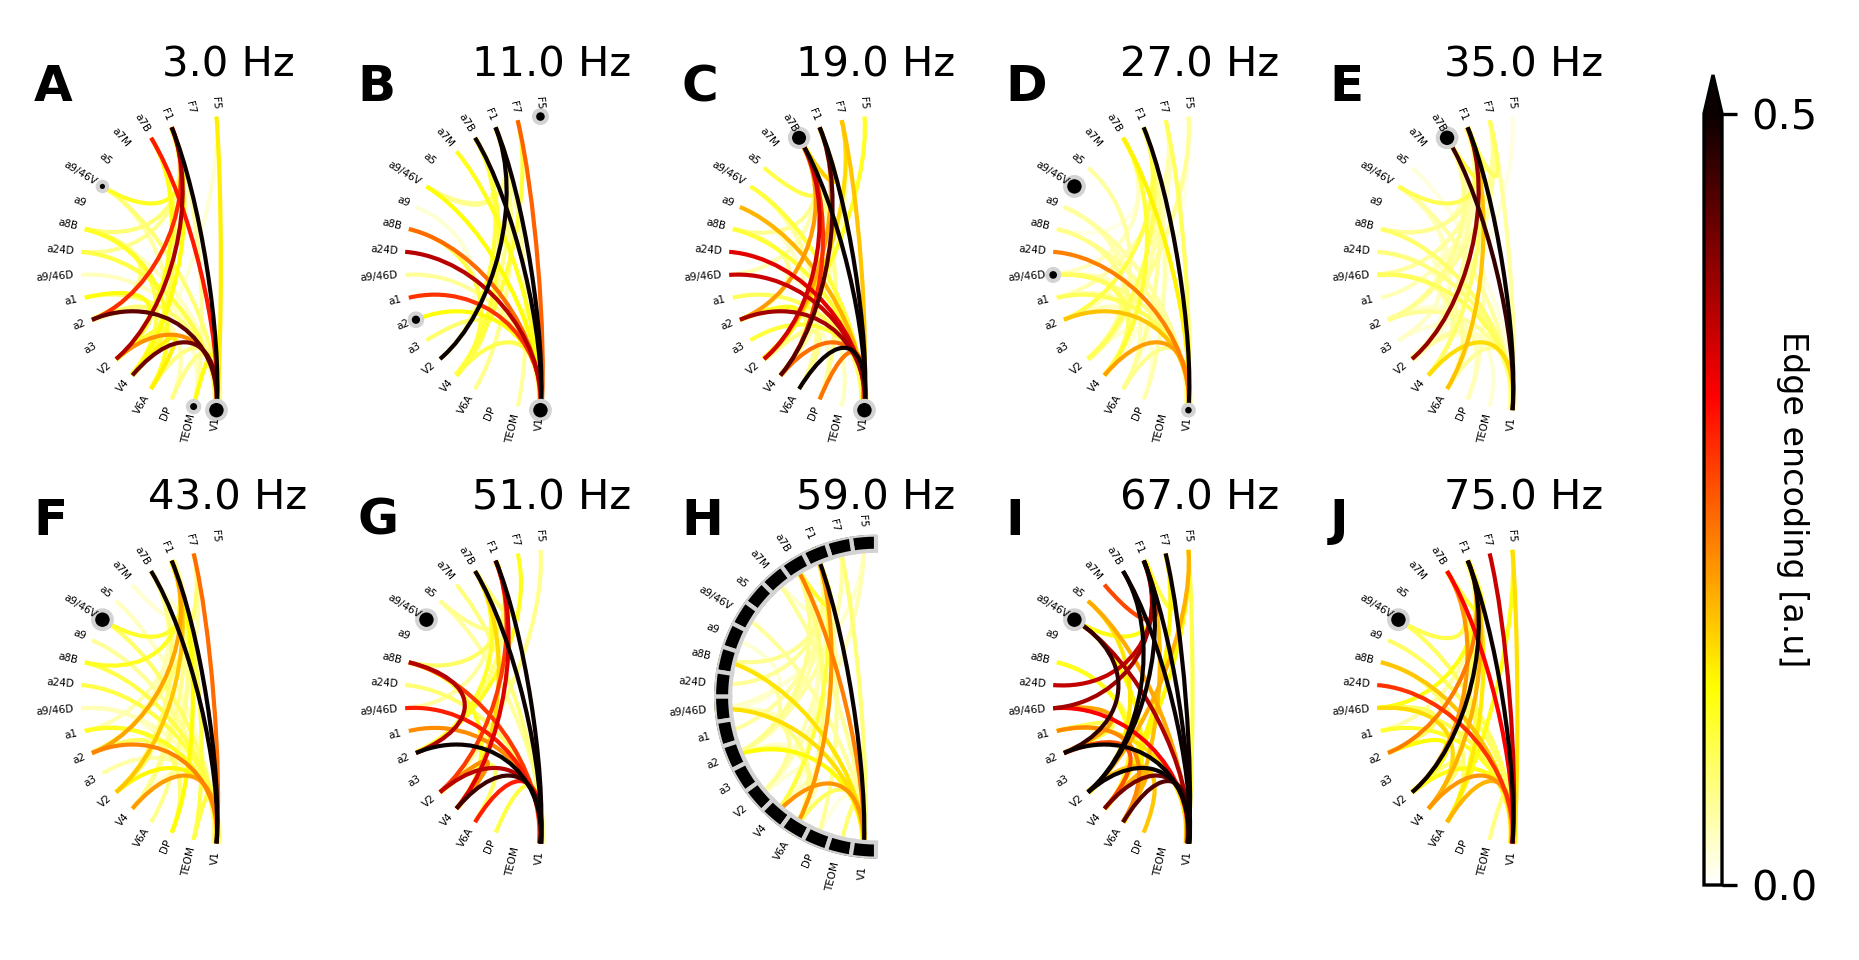

In [15]:
import matplotlib

fig = plt.figure(figsize=(6, 3), dpi=300)

gs0 = fig.add_gridspec(
    nrows=2,
    ncols=5,
    left=0.02,
    right=0.92,
    bottom=0.05,
    hspace=0.15,
    wspace=0.0,
    top=0.95,
)


gs1 = fig.add_gridspec(
    nrows=1,
    ncols=1,
    left=0.93,
    right=0.94,
    bottom=0.05,
    hspace=0.3,
    wspace=0.0,
    top=0.95,
)

axs0 = [plt.subplot(gs0[i], polar=True) for i in range(10)]

for fi, freqs in enumerate(t_coh.freqs.data):

    nodes_size = t_pow.sel(freqs=freqs, times=3).sel(roi=rois_order)

    conn, rois = to_mat(
        t_coh.sel(freqs=freqs, times=0).to_dataframe("mean_coh").reset_index(),
        "mean_coh",
    )

    conn = xr.DataArray(conn, dims=("sources", "targets"), coords=(rois, rois)).sel(
        sources=rois_order.data, targets=rois_order.data
    )

    nodes_size = 10 * (nodes_size / np.max(nodes_size)) ** 2
    conn = (conn / np.max(conn)) ** 3
    plot_conn_circle(
        conn,
        edges_cmap="hot_r",
        nodes_cmap="Greys",
        angle_span=180,
        nodes_size=nodes_size.data,
        nodes_label_fz=2.5,
        nodes_label_shift=0.3,
        nodes_size_min=0,
        nodes_size_max=20,
        cbar=False,
        edges_vmin=0.0,
        edges_vmax=0.5,
        edges_lw=1,
        ax=axs0[fi],
    )

    plt.title(f"{freqs} Hz", fontsize=10)

axs1 = plt.subplot(gs1[0])

norm = matplotlib.colors.Normalize(vmin=0, vmax=0.5)
cmap = matplotlib.cm.get_cmap("hot_r")

cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ticks=[0, 0.5],
    cax=axs1,
    extend="max",
)
cbar.ax.set_ylabel("Edge encoding [a.u]", fontsize=8, rotation=270, labelpad=-2)

plot.add_panel_letters(
    fig,
    axes=axs0,
    fontsize=12,
    xpos=[-0.1] * len(axs0),
    ypos=[1.0] * len(axs0),
)


bg = plot.Background(visible=False)

plt.savefig("figures/n6/figure13_base_ethyl.pdf")

### Is coherence and coherence encoding linked to crackling

In [16]:
data_loader = loader(_ROOT=_ROOT)

In [17]:
coh_file = f"coh_at_cue.nc"
coh_sig_file = f"thr_coh_at_cue_surr.nc"

net = temporal_network(
    coh_file=coh_file,
    coh_sig_file=coh_sig_file,
    wt=None,
    date="110704",
    trial_type=[1], monkey=monkey,
    behavioral_response=[1],
)

In [18]:
out = []
for t0, tf in stages:
    out += [
        edge_xr_remove_sca(
            xr_remove_same_roi(
                net.super_tensor.sel(times=slice(t0, tf)).mean(("times", "trials"))
            )
        )
    ]

In [19]:
out = xr.concat(out, "times")

In [20]:
out = out.groupby("roi").mean("roi")

In [21]:
cc_s_tf = []
kij_s_vec = []
for tt in [1, 2]:

    kij = data_loader.load_co_crakcle(session="110704", trial_type=tt, strength=False, monkey="ethyl")

    nrois, _, nfreqs, ntimes = kij.shape
    rois, freqs, times = kij.sources.data, kij.freqs.data, kij.times.data
    i, j = net.super_tensor.attrs["sources"], net.super_tensor.attrs["targets"]
    edges = [f"{s}-{t}" for s, t in zip(rois[i], rois[j])]

    kij_s = np.zeros((len(i), nfreqs, ntimes))

    for p, (s, t) in enumerate(zip(i, j)):
        kij_s[p, ...] = kij[s, t, ...]

    kij_s = xr.DataArray(
        kij_s, dims=("roi", "freqs", "times"), coords=(edges, freqs, times)
    )

    kij_s = edge_xr_remove_sca(xr_remove_same_roi(kij_s))

    cc_s = np.zeros((2, 10, 5))
    for f in range(10):
        for t in range(5):
            cc_s[:, f, t] = confidence_interval(
                draw_bs_pairs_reps_pearson(
                    kij_s.groupby("roi").mean("roi").sel(times=t).isel(freqs=f).data,
                    np.log(out.sel(times=t).isel(freqs=f).data),
                    size=1000,
                ),
                verbose=False,
            )

    cc_s_tf += [cc_s]
    kij_s_vec += [kij_s]

In [22]:
def plot_circle_encoding(ax, freq, time):

    areas_dict = get_areas()
    regions = np.asarray([areas_dict[roi.lower()] for roi in t_pow.roi.data])
    idx = np.argsort(regions)
    rois_order = t_pow.isel(roi=idx).roi

    nodes_size = t_pow.sel(freqs=freq, times=time).sel(roi=rois_order)

    conn, rois = to_mat(
        t_coh.sel(freqs=freqs, times=time).to_dataframe("mean_coh").reset_index(),
        "mean_coh",
    )

    conn = xr.DataArray(conn, dims=("sources", "targets"), coords=(rois, rois)).sel(
        sources=rois_order.data, targets=rois_order.data
    )

    #nodes_size = 10 * (nodes_size / np.max(nodes_size)) ** 2
    # conn = (conn / t_coh.sel(freqs=35).max()) ** 5

    plot_conn_circle(
        conn,
        edges_cmap="hot_r",
        nodes_cmap="Greys",
        angle_span=360,
        nodes_size=nodes_size.data,
        nodes_label_fz=5,
        nodes_label_shift=0.3,
        nodes_size_min=0,
        nodes_size_max=10,
        cbar=False,
        edges_vmin=0,
        edges_vmax=5,
        edges_lw=1,
        ax=ax,
    )

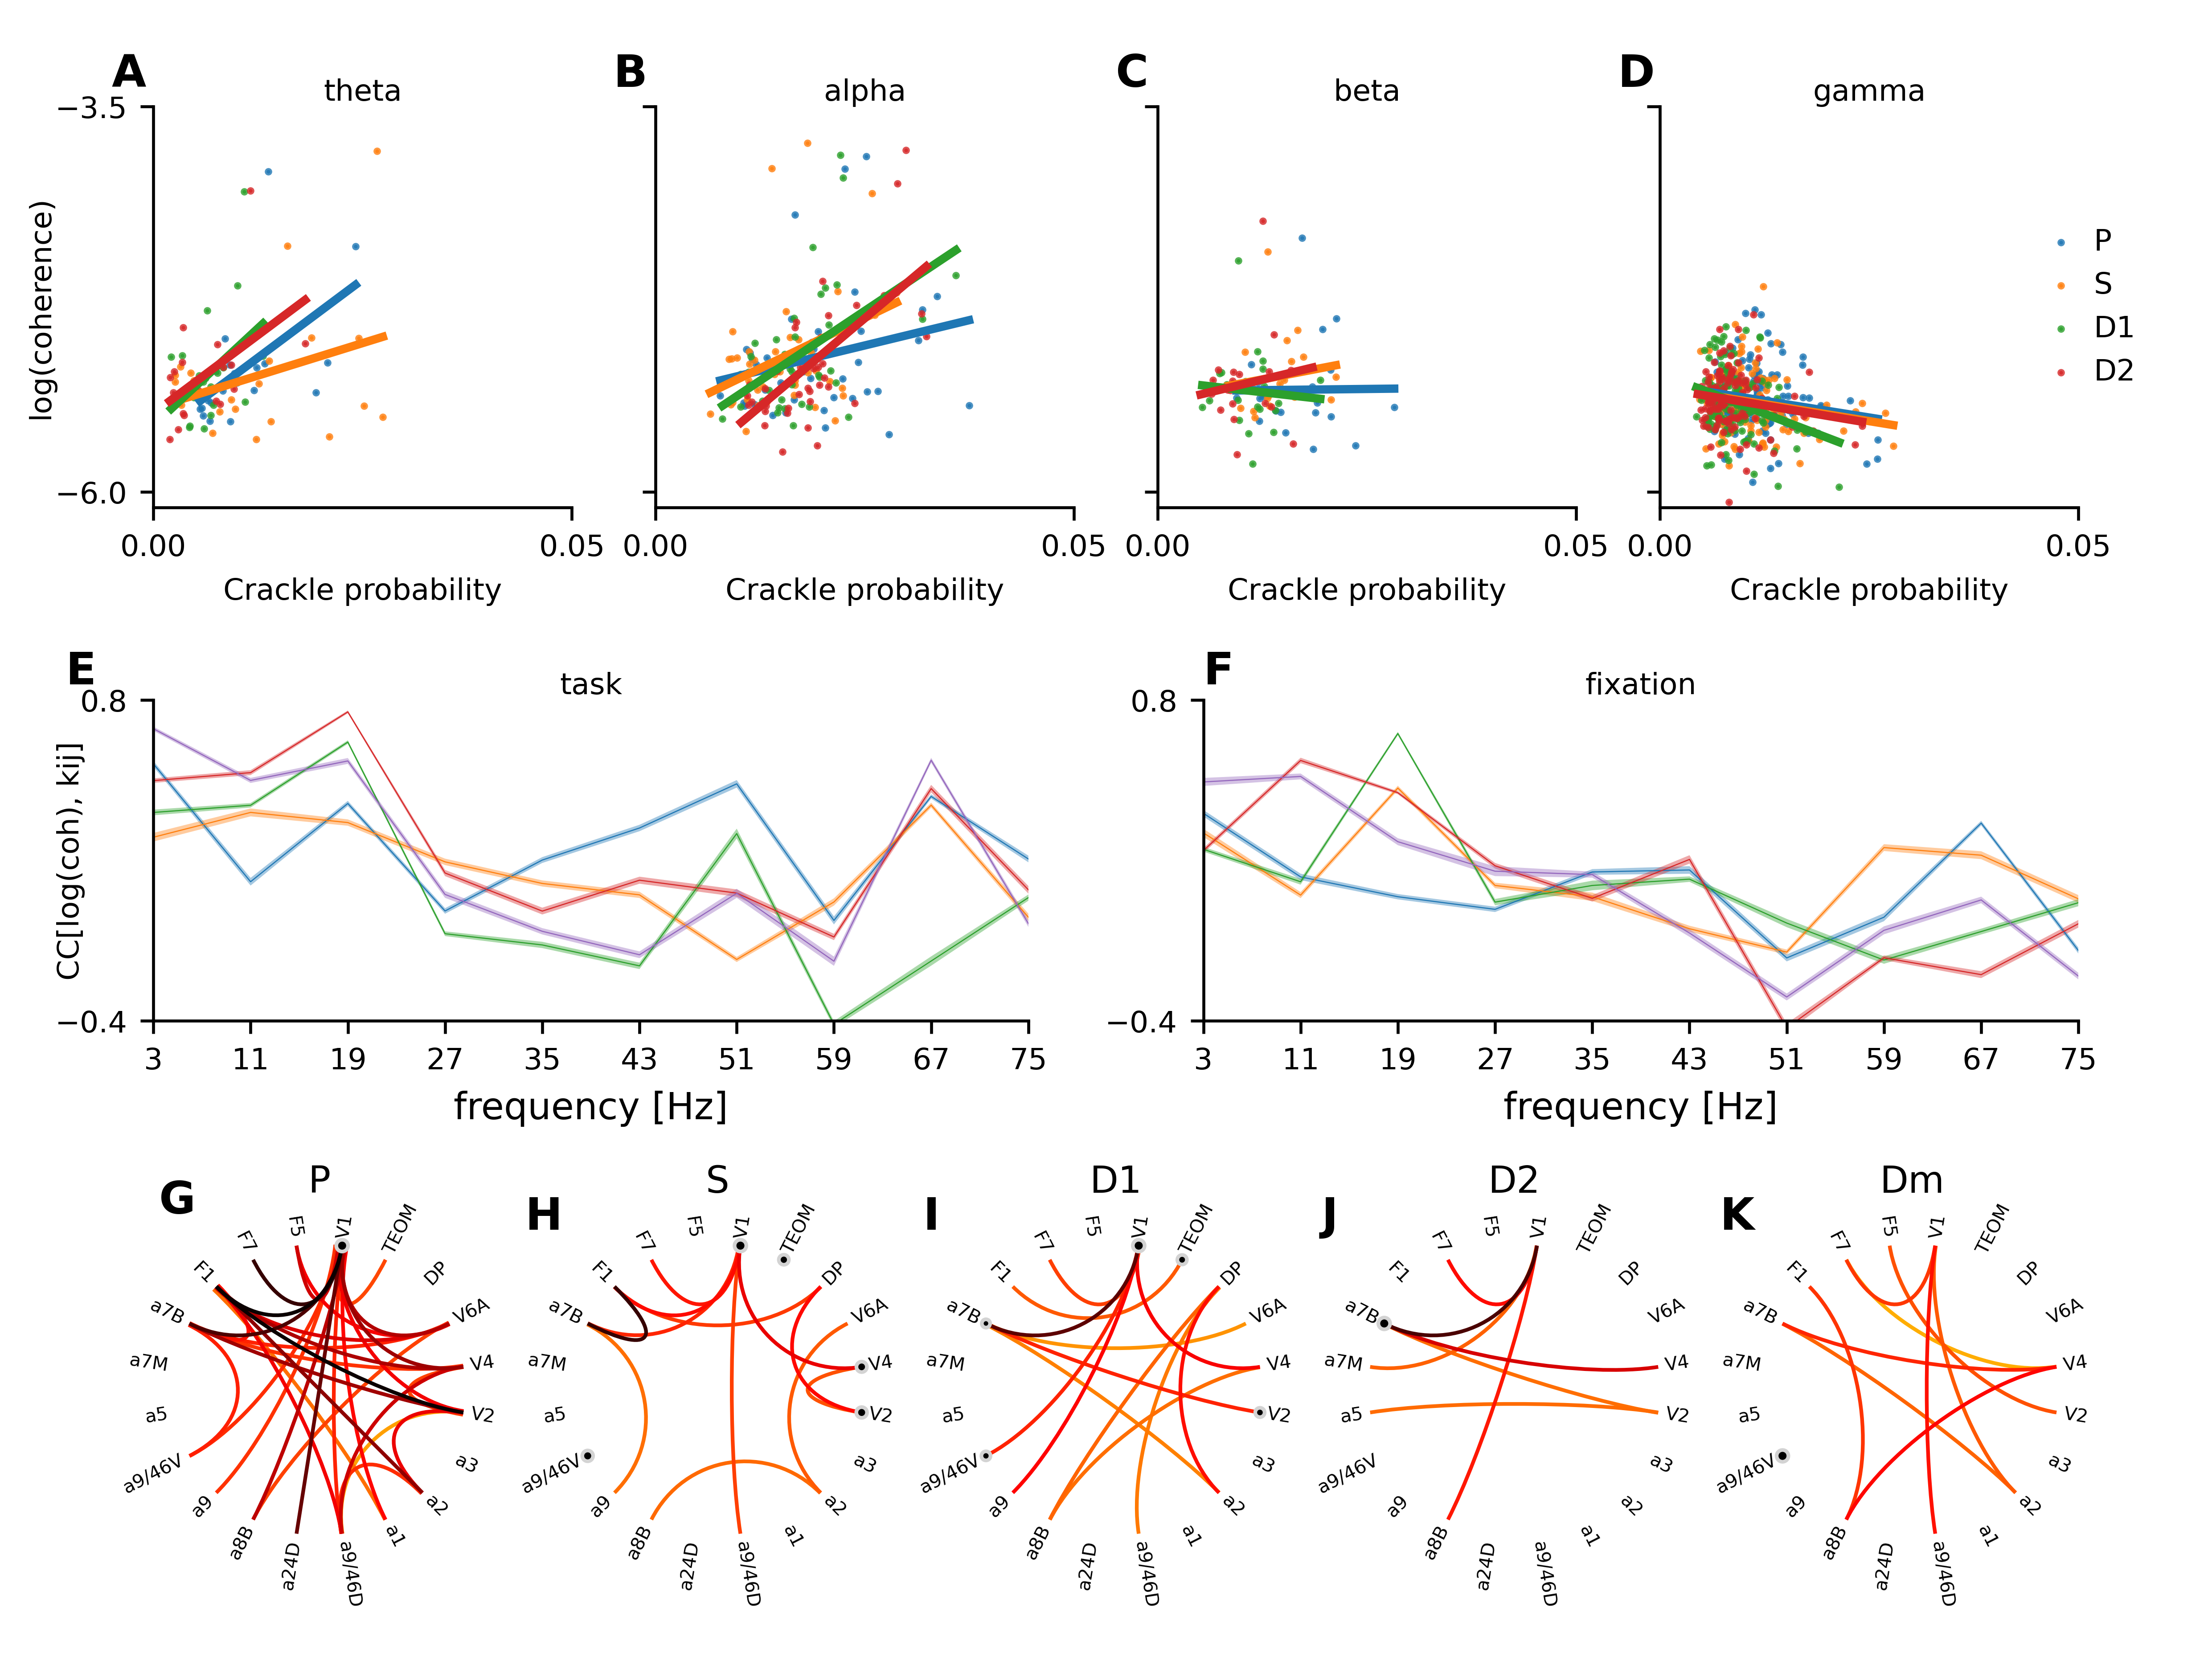

In [23]:
import matplotlib

fig = plt.figure(figsize=(8, 6), dpi=600)

gs0 = fig.add_gridspec(nrows=1, ncols=4, left=0.05, right=0.95, bottom=0.7, top=0.95)

# gs0_ax = fig.add_gridspec(nrows=1, ncols=1, left=0.92, right=0.93, bottom=0.7, top=0.87)

gs1 = fig.add_gridspec(
    nrows=1, ncols=2, left=0.05, right=0.95, bottom=0.38, top=0.58, wspace=0.2
)

gs2 = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.95, bottom=0.05, top=0.25)

axs0 = [plt.subplot(gs0[i]) for i in range(4)]
# axs0_ax = plt.subplot(gs0_ax[0])
axs1 = [plt.subplot(gs1[i]) for i in range(2)]
axs2 = [plt.subplot(gs2[i], polar=True) for i in range(5)]

################################################################################################
# Plot networks
################################################################################################
for time, ax in enumerate(axs2):
    plot_circle_encoding(ax, 35, time)
    plt.title(f"{stage_labels[time]}", fontsize=10, pad=10)
"""
norm = matplotlib.colors.Normalize(vmin=0, vmax=8)
cmap = matplotlib.cm.get_cmap("hot_r")

cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ticks=[0, 5],
    cax=axs0_ax,
    extend="max",
)
cbar.ax.set_ylabel("Edge encoding [a.u]", fontsize=8, rotation=270, labelpad=6)
"""

################################################################################################
# Scatter plots
################################################################################################
for pos, (fl, fh) in enumerate(bands):
    for t in range(4):
        plt.sca(axs0[pos])
        sns.regplot(
            x=kij_s_vec[0]
            .groupby("roi")
            .mean("roi")
            .sel(times=t)
            .sel(freqs=slice(fl, fh))
            .data.flatten(),
            y=np.log(out.sel(times=t).sel(freqs=slice(fl, fh)).data.flatten()),
            ci=None,
            scatter_kws={"s": 1},
            label=f"{stage_labels[t]}",
        )
        plt.ylim(-6.1, -3.5)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)

    plt.xticks([0, 0.05])
    plt.yticks([-6, -3.5])
    if pos > 0:
        plt.setp(axs0[pos].get_yticklabels(), visible=False)
    else:
        plt.ylabel("log(coherence)", fontsize=8, labelpad=0)
    plt.xlabel("Crackle probability", fontsize=8)
    plt.title(f"{band_names[pos]}", fontsize=8, pad=-1)
axs0[pos].legend(
    loc="right",
    bbox_to_anchor=(1.2, 0.5),
    ncol=1,
    fontsize=8,
    frameon=False,
    handletextpad=0.1,
)

[axs0[pos].spines["top"].set_visible(False) for pos in range(4)]
[axs0[pos].spines["right"].set_visible(False) for pos in range(4)]

################################################################################################
# Correlations
################################################################################################
titles = ["task", "fixation"]
for pos in range(2):
    plt.sca(axs1[pos])
    [plt.plot(kij_s.freqs, cc_s_tf[pos][..., t].mean(0), lw=0.3) for t in range(5)]
    [
        plt.fill_between(
            kij_s.freqs, cc_s_tf[pos][0, :, t], cc_s_tf[pos][1, :, t], alpha=0.4
        )
        for t in range(5)
    ]
    if pos == 0: plt.ylabel("CC[log(coh), kij]", fontsize=8, labelpad=-8)
    plt.xlim(3, 75)
    plt.xticks(t_coh.freqs.data, fontsize=8)
    plt.yticks([-0.4, 0.8], fontsize=8)
    plt.title(f"{titles[pos]}", fontsize=8, pad=0)
    plt.ylim([-0.4, 0.8])
    plt.xlabel("frequency [Hz]")
[axs1[pos].spines["top"].set_visible(False) for pos in range(2)]
[axs1[pos].spines["right"].set_visible(False) for pos in range(2)]


plot.add_panel_letters(
    fig,
    axes=axs0 + axs1 + axs2,
    fontsize=12,
    xpos=[-0.1] * 5 + [-0.] * 2 + [-0.1] * 5,
    ypos=[1.05] * 7 + [1.0] * 5,
)

bg = plot.Background(visible=False)

plt.savefig("figures/n6/figure14_ethyl.pdf")

In [14]:
import numba as nb

In [15]:
##############################################################################
# utility functions
###############################################################################
@nb.jit(nopython=True)
def co_crackling_adj(A):
    """
    Calculate the co-crackling matrix for a given matrix adjacency.

    Parameters:
    A (ndarray): matrix of community assignments where rows are rois and
    columns are time points
    Returns:
    ndarray: 3-D co-crackling matrix, where the last dimension corresponds
    to time point.
    """
    nroi, nobs = A.shape

    out = np.zeros((nroi, nroi, nobs), dtype=np.int8)

    for T in range(nobs):
        idx = A[:, T]
        out[..., T] = np.outer(idx, idx)

    return out


def order_rois(rois, x_s, x_t):
    roi_low = np.asarray([r.lower() for r in rois])
    _xs, _xt = x_s.copy(), x_t.copy()
    x_s, x_t = [], []
    for s, t in zip(_xs, _xt):
        _pair = np.array([roi_low[s], roi_low[t]])
        if np.all(_pair == np.sort(_pair)):
            x_s.append(s)
            x_t.append(t)
        else:
            x_s.append(t)
            x_t.append(s)
    return np.asarray(x_s), np.asarray(x_t)


def co_crackle_mat(A, verbose=False, n_jobs=1):
    """
    Compute co-crackle matrix and consensus vectors for given input data.

    This function computes co-crackle matrix and consensus vectors for the
    given input data. It first computes co-crackling adjacency matrix and then
    computes the mean of the matrix over the observation dimension. Finally,
    it computes consensus vectors for each time step by calling the
    'return_consensus_vector' function.

    Parameters:
    A (xarray.DataArray): Input data.
    nruns (int, optional): Number of runs for consensus vector calculation.
    Default is 100.

    Returns:
    kij (xarray.DataArray): Co-crackle matrix.
    ci (xarray.DataArray): Consensus vector for each time step.
    """
    rois = A.roi.data
    freqs = A.freqs.data
    times = A.times.data
    trials = A.trials.data

    nroi, nfreqs, ntrials, ntimes = A.shape

    A = A.stack(obs=("trials", "times")).data

    def _for_freq(f):
        co_k = co_crackling_adj(A[:, f, :])
        return co_k

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        _for_freq, n_jobs=n_jobs, verbose=False, total=nfreqs
    )
    # Compute surrogate for each frequency
    co_k = parallel(p_fun(f) for f in range(nfreqs))

    co_k = np.stack(co_k, axis=2).reshape((nroi, nroi, nfreqs, ntrials, ntimes))

    x_s, x_t = np.triu_indices(nroi, k=1)
    npairs = len(x_s)
    x_s, x_t = order_rois(rois, x_s, x_t)

    roi_s, roi_t = rois[x_s], rois[x_t]
    roi_st = np.asarray([f"{s}-{t}" for s, t in zip(roi_s, roi_t)])

    co_k_stream = np.zeros((npairs, nfreqs, ntrials, ntimes), dtype=np.int8)

    for p, (i, j) in enumerate(zip(x_s, x_t)):
        co_k_stream[p, ...] = co_k[i, j, ...]

    co_k = xr.DataArray(
        co_k_stream,
        dims=("roi", "freqs", "trials", "times"),
        coords=(roi_st, freqs, trials, times),
    )

    return co_k

In [16]:
tt = br = 1
at = "cue"
q = 0.9
co_k_sessions = []
for s_id in tqdm(sessions):
    _FILE_NAME = f"power_tt_{tt}_br_{br}_at_{at}.nc"
    path_pow = os.path.join(_ROOT, f"Results/{monkey}/{s_id}/session01", _FILE_NAME)
    power = xr.load_dataarray(path_pow)
    attrs = power.attrs

    # Compute activation time-series
    thr = power.quantile(q, ("trials", "times"))
    # Binarized power
    power = (power >= thr).transpose("roi", "freqs", "trials", "times")

    # Computes co-crackling matrices
    co_k = co_crackle_mat(power, verbose=False, n_jobs=10)

    out = []
    for t0, t1 in stages:
        out += [co_k.sel(times=slice(t0, t1)).mean("times")]
    out = xr.concat(out, "times")
    out = out.transpose("trials", "roi", "freqs", "times")
    co_k_sessions += [out.mean("trials")]
    del co_k, out

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  4%|▍         | 1/25 [00:03<01:34,  3.94s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

  8%|▊         | 2/25 [00:06<01:06,  2.88s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 12%|█▏        | 3/25 [00:15<02:05,  5.69s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 16%|█▌        | 4/25 [00:20<01:53,  5.38s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 20%|██        | 5/25 [00:27<02:00,  6.01s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 24%|██▍       | 6/25 [00:34<02:03,  6.49s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 28%|██▊       | 7/25 [00:47<02:34,  8.60s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 32%|███▏      | 8/25 [00:53<02:14,  7.88s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 36%|███▌      | 9/25 [01:02<02:10,  8.18s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 40%|████      | 10/25 [01:05<01:36,  6.45s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 44%|████▍     | 11/25 [01:14<01:40,  7.17s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 48%|████▊     | 12/25 [01:15<01:11,  5.53s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 52%|█████▏    | 13/25 [01:21<01:06,  5.57s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 56%|█████▌    | 14/25 [01:28<01:06,  6.08s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 60%|██████    | 15/25 [01:35<01:03,  6.33s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 64%|██████▍   | 16/25 [01:45<01:07,  7.47s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 68%|██████▊   | 17/25 [01:54<01:01,  7.70s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 72%|███████▏  | 18/25 [01:55<00:40,  5.81s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 76%|███████▌  | 19/25 [01:58<00:30,  5.11s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 80%|████████  | 20/25 [02:04<00:26,  5.26s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 84%|████████▍ | 21/25 [02:10<00:21,  5.43s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 88%|████████▊ | 22/25 [02:17<00:17,  5.87s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 92%|█████████▏| 23/25 [02:25<00:13,  6.68s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

 96%|█████████▌| 24/25 [02:34<00:07,  7.16s/it]

  0%|          |  : 0/10 [00:00<?,       ?it/s]

100%|██████████| 25/25 [02:40<00:00,  6.41s/it]


In [17]:
out = xr.concat(co_k_sessions, "roi").groupby("roi").mean("roi")
out = out.sel(roi=t_coh.roi)
out = xr_remove_same_roi(out)
tvals = xr_remove_same_roi(t_coh)
rois = out.roi.data
times = out.times.data
freqs = out.freqs.data
nboot = 1000
cc = np.zeros((nboot, len(freqs), len(times)))

for i, freq in enumerate(freqs):
    for j, time in enumerate(times):
        x = out.sel(freqs=freq, times=time)
        y = tvals.sel(freqs=freq, times=time)
        cc[:, i, j] = draw_bs_pairs_reps_pearson(x, y, size=nboot)

cc = xr.DataArray(
    cc, dims=("boot", "freqs", "times"), coords=dict(freqs=freqs, times=times)
)
# cc = confidence_interval(cc, axis=0).squeeze()

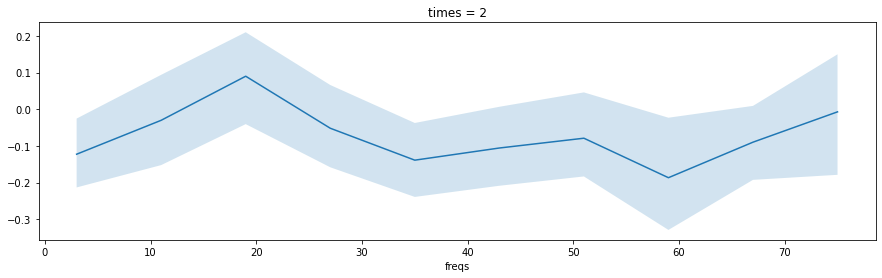

In [23]:
plt.figure(figsize=(15, 4))
for i in range(5):
    cc.median("boot").sel(times=i).plot()
    plt.fill_between(
        freqs,
        cc.sel(times=i).quantile(0.05, "boot"),
        cc.sel(times=i).quantile(0.95, "boot"),
        alpha=0.2,
    )